# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [ ]:
!pip install nvidia-nccl-cu12==2.22.3 --user


In [ ]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==2.1.4 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

### import classes

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns

# import Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping

#import keras modules
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau

#import sklearn moddules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import cv2_imshow
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## Resuable Functions

In [ ]:
def plotLoss(history, name):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train accuracy or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

In [ ]:
# function that plots random images and labels them and indexes for reference

def plot_images(images,labels):
  num_classes=10
  categories=np.unique(labels)
  keys=dict(labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(12, 12))
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[random_index, :])
          ax.set_title(f"{keys[random_index]} ({random_index})") # Added index to title
  plt.show()


In [ ]:
#  plot images one from each unique label

def plot_images_unique(images,labels):
  num_classes=10
  categories=np.unique(labels)
  keys=dict(labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(12, 12))
  for i, category in enumerate(categories):
      # Find an image with the current category label
      index = labels[labels['Label'] == category].index[0]
      ax = fig.add_subplot(rows, cols, i + 1)
      ax.imshow(images[index, :])
      ax.set_title(f"{category} ({index})") # Added index to title
  plt.show()


## Loading the dataset

In [ ]:
# Uncomment and run the below code if you are using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load images and labels

In [ ]:
# Load image dataset
images = np.load('/content/drive/MyDrive/AIClass/computervision/project/images (2).npy')

# Load labels
labels = pd.read_csv('/content/drive/MyDrive/AIClass/computervision/project/Labels (1).csv')

## Data Overview

- Images is a numpy.ndarray of size 4750, 128, 128, 3:  
    - It has 4750 color images that are 128x128 pixels.
- Labels have 4750 rows and 1 column:  
    - The Column Name is Label is of type object.

### Understand the shape of the dataset

In [ ]:
# print shape for images and labels

print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


## Exploratory Data Analysis

EDA Findings

All images in the dataset are 128x128 pixels and feature green foliage against a gravel background. Some images contain very small foliage.

The dataset exhibits class imbalance, with "Loose Silky-bent" being the most frequent class (13.8%) and "Maize" and "Common Wheat" being the least frequent classes (4.7% each).

Some of the seedlings are very small and blend into the background, particuarlly the Black Grass and Loose Silky-bent.

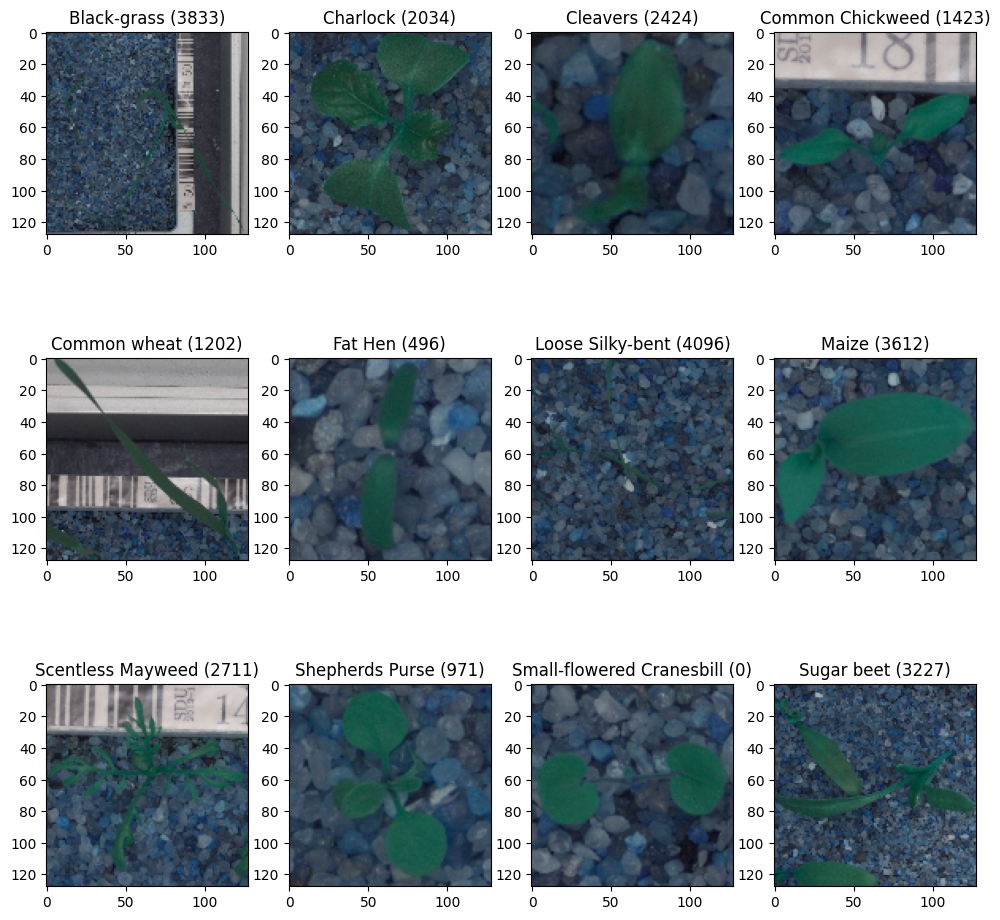

In [ ]:
plot_images_unique(images, labels)

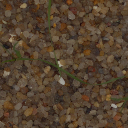

In [ ]:
cv2_imshow(images[4096])

### Distribution of Seedlings Classification

The classes in the dataset are unbalanced. The class with the most examples is "Loose Silky-bent" with 13.8% of the data, while "Maize" and "Common Wheat" have the fewest, both with 4.7%.

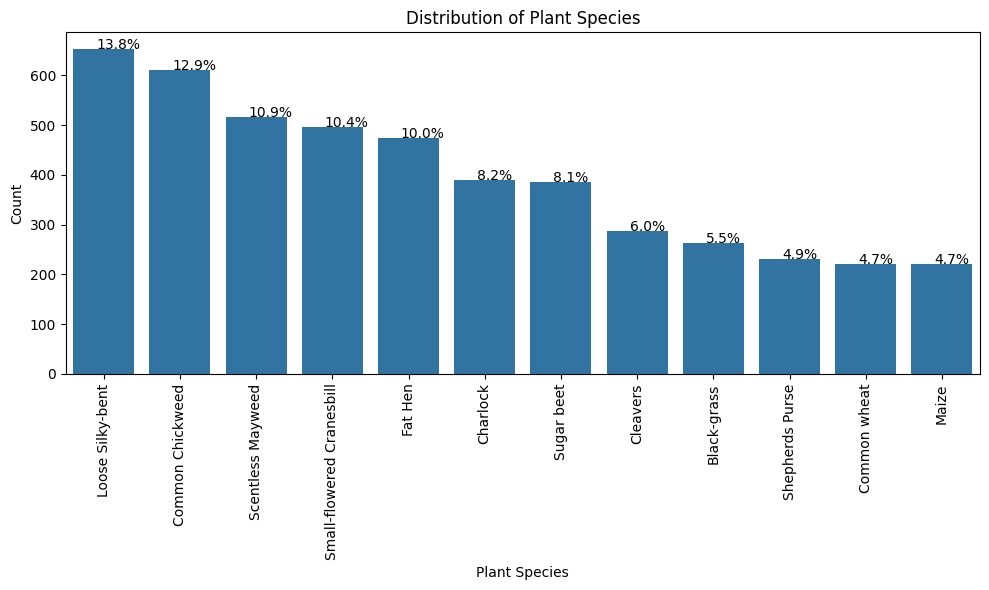

In [ ]:
# Count the occurrences of each label
label_counts = labels['Label'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Label', data=labels, order=label_counts.index)
plt.xticks(rotation=90)
plt.xlabel('Plant Species')
plt.ylabel('Count')
plt.title('Distribution of Plant Species')

# Add percentages on top of each bar
total = len(labels)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size=10)

plt.tight_layout()
plt.show()


In [ ]:
# list the count of all classes

# Count the occurrences of each label
label_counts = labels['Label'].value_counts()

# Print the counts
print(label_counts)


Label
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: count, dtype: int64


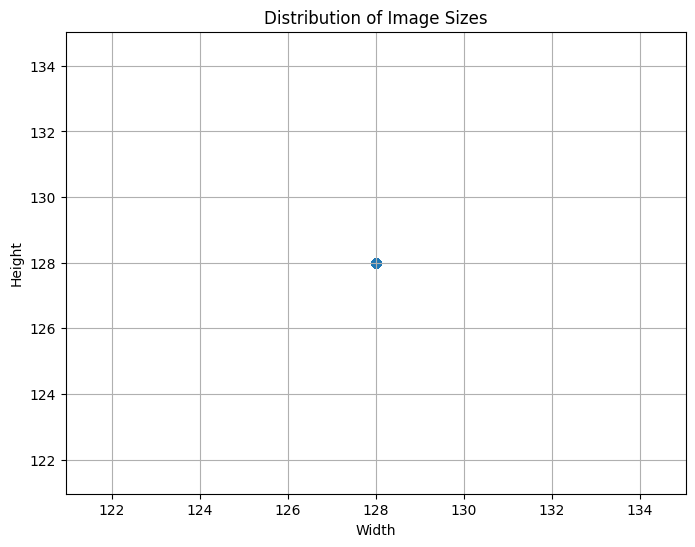

In [ ]:
#  loop through images and get images sizes and then create a scatterplot

# Get image sizes
image_sizes = [(img.shape[0], img.shape[1]) for img in images]
widths, heights = zip(*image_sizes)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribution of Image Sizes')
plt.grid(True)
plt.show()


All Images are 128x128

## Data Pre-Processing

Label    Small-flowered Cranesbill
Name: 4, dtype: object


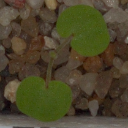

In [ ]:
# print image and label
print(labels.iloc[4])
cv2_imshow(images[4])


Label    Shepherds Purse
Name: 1000, dtype: object


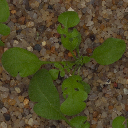

In [ ]:
print(labels.iloc[1000])
cv2_imshow(images[1000])

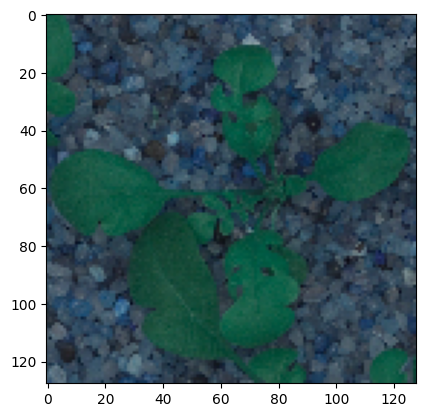

In [ ]:
# visualize image in matplot lib
plt.imshow(images[1000])

The images are currently in BGR format and need to be converted to RGB.

### Convert the BGR images to RGB images.

In [ ]:
# loop through images and convert from bgr to rgb and save to new array named images_converted

images_converted = []
for image in images:
  rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images_converted.append(rgb_image)

images_converted = np.array(images_converted)


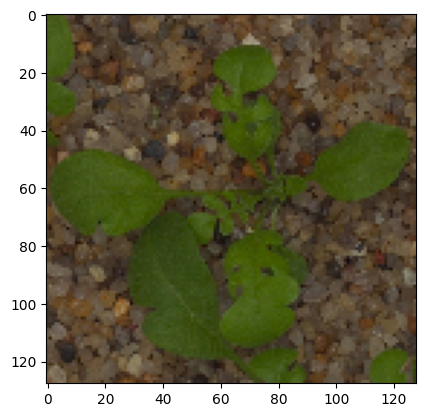

In [ ]:
plt.imshow(images_converted[1000])

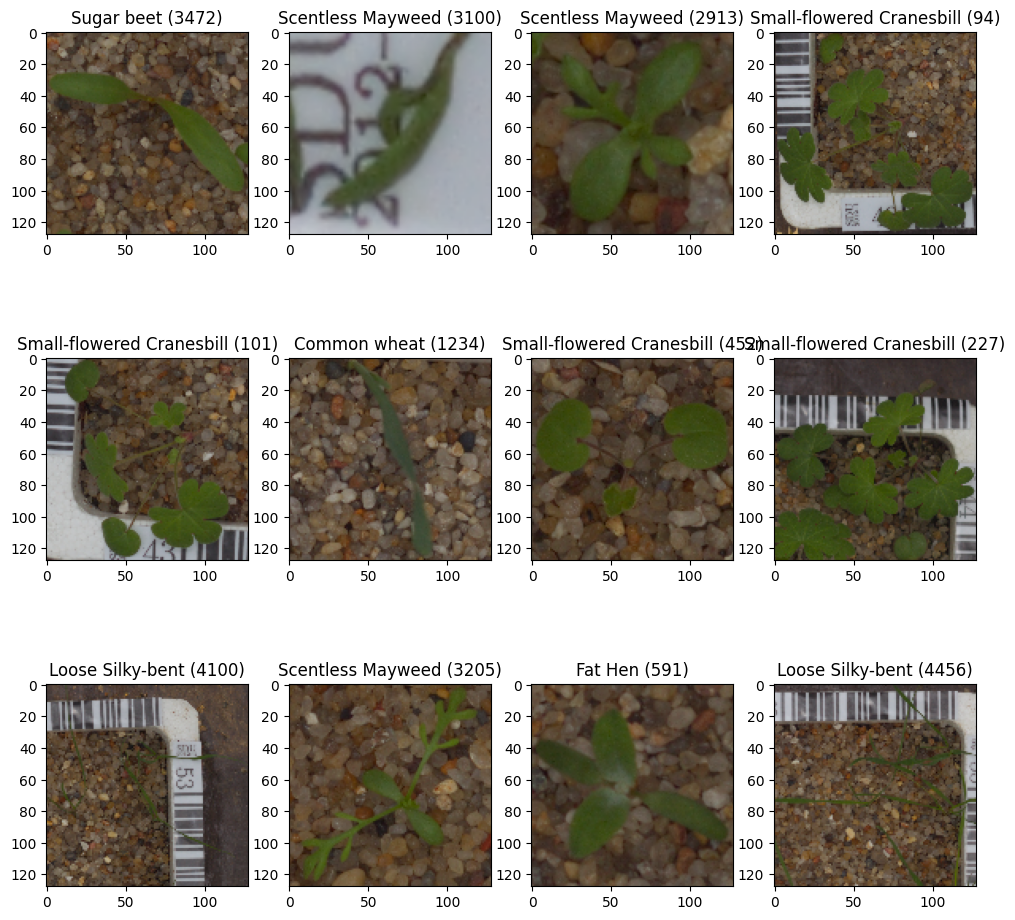

In [ ]:
# visualize converted images
plot_images(images_converted, labels)

### Resize the images

Given the substantial computational overhead associated with training on large images, a dimensionality reduction strategy was implemented. To balance computational efficiency and preservation of relevant image features, the image size was downscaled from 128x128 to 96x96.

This decision was informed by the observation that a significant proportion of images contained minute foliage details, necessitating a resolution higher than 64x64. Leveraging GPU acceleration for model training was a key consideration in this optimization.

In [ ]:
# decrease images to 96x96 and store in images_decreased array

images_decreased=[]
height = 96
width = 96
dimensions = (width, height)

for i in range(len(images_converted)):
 images_decreased.append( cv2.resize(images_converted[i], dimensions, interpolation=cv2.INTER_LINEAR))



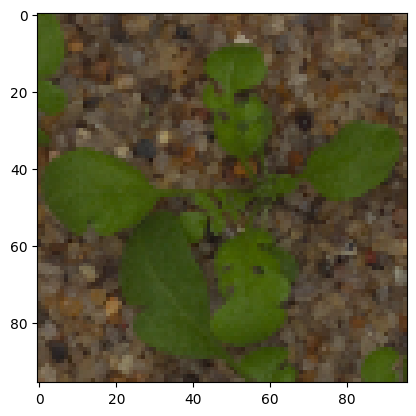

In [ ]:
# visualize image

plt.imshow(images_decreased[1000])

### Data Preparation for Modeling

**Create and populate X and y parameters**

In [ ]:
# populate features and labels X,y
X = np.array(images_decreased)
y = labels['Label']

### **Split the dataset**

80% for training
10% for test
10% for validation

In [ ]:
# spliting the dataset into test, train and val
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.11111111, random_state=42,stratify=y_temp)

Validate distribution of training and validation data

In [ ]:
# Calculate percentage of values for each unique label in y_val
unique_labels, counts = np.unique(y_val, return_counts=True)
percentages = counts / len(y_val) * 100

for label, percentage in zip(unique_labels, percentages):
    print(f"{label}: {percentage:.2f}%")


Black-grass: 5.47%
Charlock: 8.21%
Cleavers: 6.11%
Common Chickweed: 12.84%
Common wheat: 4.63%
Fat Hen: 9.89%
Loose Silky-bent: 13.68%
Maize: 4.63%
Scentless Mayweed: 10.95%
Shepherds Purse: 4.84%
Small-flowered Cranesbill: 10.53%
Sugar beet: 8.21%


In [ ]:
# Calculate percentage of values for each unique label in y_train
unique_labels, counts = np.unique(y_train, return_counts=True)
percentages = counts / len(y_train) * 100

for label, percentage in zip(unique_labels, percentages):
    print(f"{label}: {percentage:.2f}%")

Black-grass: 5.55%
Charlock: 8.21%
Cleavers: 6.03%
Common Chickweed: 12.87%
Common wheat: 4.66%
Fat Hen: 10.00%
Loose Silky-bent: 13.79%
Maize: 4.66%
Scentless Mayweed: 10.84%
Shepherds Purse: 4.87%
Small-flowered Cranesbill: 10.42%
Sugar beet: 8.11%


In [ ]:
# Calculate percentage of values for each unique label in y_test
unique_labels, counts = np.unique(y_test, return_counts=True)
percentages = counts / len(y_test) * 100

for label, percentage in zip(unique_labels, percentages):
    print(f"{label}: {percentage:.2f}%")

Black-grass: 5.47%
Charlock: 8.21%
Cleavers: 6.11%
Common Chickweed: 12.84%
Common wheat: 4.63%
Fat Hen: 10.11%
Loose Silky-bent: 13.68%
Maize: 4.63%
Scentless Mayweed: 10.95%
Shepherds Purse: 4.84%
Small-flowered Cranesbill: 10.53%
Sugar beet: 8.00%


The distribution of classes in the training and validation datasets are very similar.

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (3800, 96, 96, 3)
Shape of X_test: (475, 96, 96, 3)
Shape of X_val: (475, 96, 96, 3)
Shape of y_train: (3800,)
Shape of y_test: (475,)
Shape of y_val: (475,)


### Encode the target labels

In [ ]:
#encode target variables using LabelBinarizer

from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

###  List Labels and Class

In [ ]:
# list label and index or classes for future reference

for i in range(len(enc.classes_)):
  print(enc.classes_[i], ":", i)

Black-grass : 0
Charlock : 1
Cleavers : 2
Common Chickweed : 3
Common wheat : 4
Fat Hen : 5
Loose Silky-bent : 6
Maize : 7
Scentless Mayweed : 8
Shepherds Purse : 9
Small-flowered Cranesbill : 10
Sugar beet : 11


### Data Normalization

In [ ]:
# normalize images

X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

### Model 1

Our baseline model is a convolutional neural network (CNN) designed for image classification. It consists of six convolutional layers, each followed by a max pooling layers. After the convolutional layers, we flatten the representation and pass it through three fully connected (dense) layers. Finally, a softmax output layer provides the predicted probabilities for each of the twelve plant species.

In [ ]:
# clear session
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
model1 = Sequential()

model1.add(Conv2D(256, (3, 3), activation='relu', padding="same", input_shape=(96, 96, 3)))
#add the a poooling layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# adding conv and pooling
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# adding conv and pooling
model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))


model1.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))


# Flatten the layers
model1.add(Flatten())

# Start fully connected model

model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='relu'))
# ouput layer
model1.add(Dense(12, activation='softmax'))

# defining adam optimizer
opt=Adam()



In [ ]:
# compiling model using accuracy metric
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0

### Trainable parameters

The model has ~405K trainable parameters

#### Early stopping



In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

#### Train Model 1

In [ ]:
# fit the models on train and validation datasets

history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=2,
            callbacks=[early_stopping]
)

Epoch 1/50
60/60 - 13s - loss: 2.4445 - accuracy: 0.1337 - val_loss: 2.4285 - val_accuracy: 0.1389 - 13s/epoch - 223ms/step
Epoch 2/50
60/60 - 3s - loss: 2.4225 - accuracy: 0.1358 - val_loss: 2.4230 - val_accuracy: 0.1263 - 3s/epoch - 53ms/step
Epoch 3/50
60/60 - 3s - loss: 2.4185 - accuracy: 0.1495 - val_loss: 2.4146 - val_accuracy: 0.1495 - 3s/epoch - 53ms/step
Epoch 4/50
60/60 - 3s - loss: 2.4063 - accuracy: 0.1568 - val_loss: 2.3991 - val_accuracy: 0.1558 - 3s/epoch - 53ms/step
Epoch 5/50
60/60 - 3s - loss: 2.2476 - accuracy: 0.2189 - val_loss: 1.9972 - val_accuracy: 0.2842 - 3s/epoch - 53ms/step
Epoch 6/50
60/60 - 3s - loss: 1.8424 - accuracy: 0.3592 - val_loss: 1.8435 - val_accuracy: 0.3284 - 3s/epoch - 53ms/step
Epoch 7/50
60/60 - 3s - loss: 1.6551 - accuracy: 0.4174 - val_loss: 1.7171 - val_accuracy: 0.4042 - 3s/epoch - 52ms/step
Epoch 8/50
60/60 - 3s - loss: 1.5634 - accuracy: 0.4350 - val_loss: 1.4758 - val_accuracy: 0.4674 - 3s/epoch - 54ms/step
Epoch 9/50
60/60 - 3s - loss:

### Metric Evaluation

Given the importance of accurate seedling identification, we will prioritize models with the highest overall accuracy.

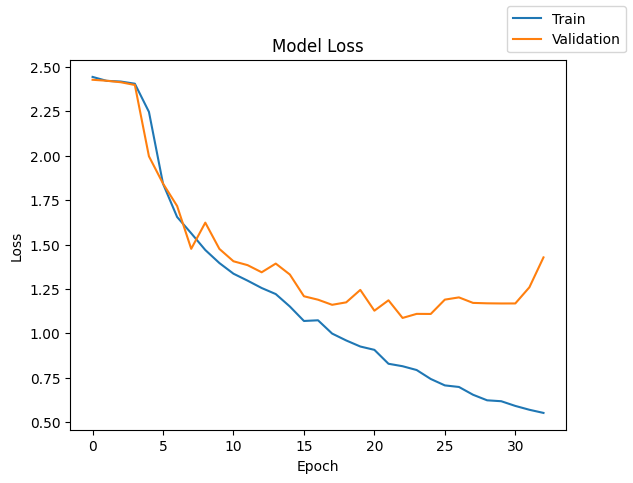

In [ ]:
# plot loss for model1
plotLoss(history_1, 'loss')

The plot shows the training and validation loss of a CNN model over 40 epochs. Both training and validation loss decreased steadily during the early epochs, indicating effective learning. However, after around 20 epochs, the validation loss began to plateau or slightly increase while the training loss continued to decrease. This suggests a potential overfitting issue, where the model is learning patterns specific to the training data but struggling to generalize to unseen data.

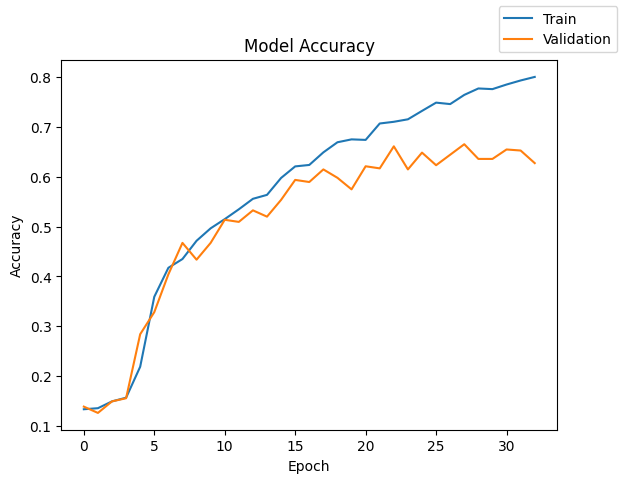

In [ ]:
# plot accuracy for model1
plotLoss(history_1, 'accuracy')

In [ ]:
accTrain = model1.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accTrain

119/119 - 2s - loss: 0.7372 - accuracy: 0.7363 - 2s/epoch - 15ms/step


[0.7371588349342346, 0.7363157868385315]

In [ ]:
accVal = model1.evaluate(X_val_normalized, y_val_encoded, verbose=2)
accVal

15/15 - 0s - loss: 1.0863 - accuracy: 0.6611 - 190ms/epoch - 13ms/step


[1.0862642526626587, 0.6610526442527771]

#### Model 1 - Metric Evaluation

The model is achieving a training accuracy of 0.74, while the validation accuracy is 0.66. This difference suggests the model is overfitting the training data. While the training accuracy is decent, the lower validation accuracy indicates there's room for improvement in the model's ability to generalize to unseen data.




In [ ]:
# calculate y_pred for validation
y_pred=model1.predict(X_val_normalized)

15/15 [==============================] - 0s 11ms/step


15/15 [==============================] - 0s 11ms/step


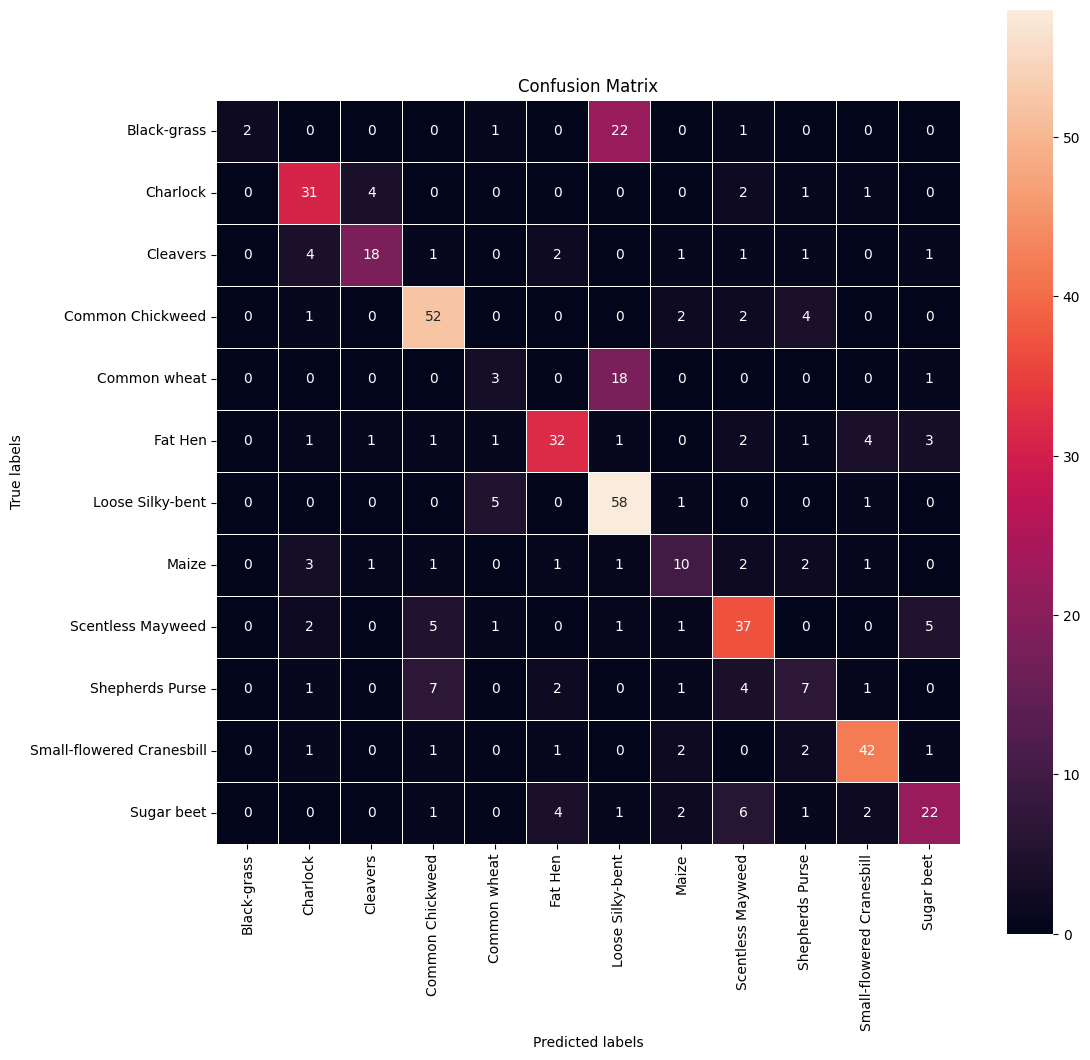

In [ ]:
# plot a confusion matrix for y_val_encoded

# calculate y_pred for validation
y_pred=model1.predict(X_val_normalized)

# Obtaining the categorical values from y_val_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_val_arg=np.argmax(y_val_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_val_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=0)
plt.show()


Model 1 exhibits a notable propensity for misclassifying certain seedling types. Specifically, the model demonstrates confusion between Loose Silky-bent and Black-grass, Common Chickweed and Shepherds Purse, and Common Chickweed and Scentless Mayweed. Additionally, instances of Scentless Mayweed being misclassified as Sugar Beet were observed. These findings indicate potential challenges in the model's ability to discriminate between visually similar plant species, suggesting a need for further refinement in feature extraction or model architecture.


In [ ]:
# calculate the accuracy for each class using validation dataset

# Calculate accuracy for each class
class_accuracy = {}
for i in range(len(enc.classes_)):
    true_positives = confusion_matrix[i, i] # Remove .numpy() here
    total_samples = np.sum(confusion_matrix[i, :]) # Remove .numpy() here
    class_accuracy[enc.classes_[i]] = true_positives / total_samples if total_samples > 0 else 0

# Print accuracy for each class
for class_name, accuracy in class_accuracy.items():
    print(f"Accuracy for {class_name}: {accuracy:.2f}")

Accuracy for Black-grass: 0.08
Accuracy for Charlock: 0.79
Accuracy for Cleavers: 0.62
Accuracy for Common Chickweed: 0.85
Accuracy for Common wheat: 0.14
Accuracy for Fat Hen: 0.68
Accuracy for Loose Silky-bent: 0.89
Accuracy for Maize: 0.45
Accuracy for Scentless Mayweed: 0.71
Accuracy for Shepherds Purse: 0.30
Accuracy for Small-flowered Cranesbill: 0.84
Accuracy for Sugar beet: 0.56


In [ ]:
# calculate the precision for each class using validation dataset

# Calculate precision for each class
class_precision = {}
for i in range(len(enc.classes_)):
    true_positives = confusion_matrix[i, i]
    predicted_positives = np.sum(confusion_matrix[:, i])
    class_precision[enc.classes_[i]] = true_positives / predicted_positives if predicted_positives > 0 else 0

# Print precision for each class
for class_name, precision in class_precision.items():
    print(f"Precision for {class_name}: {precision:.2f}")


Precision for Black-grass: 1.00
Precision for Charlock: 0.70
Precision for Cleavers: 0.75
Precision for Common Chickweed: 0.75
Precision for Common wheat: 0.27
Precision for Fat Hen: 0.76
Precision for Loose Silky-bent: 0.57
Precision for Maize: 0.50
Precision for Scentless Mayweed: 0.65
Precision for Shepherds Purse: 0.37
Precision for Small-flowered Cranesbill: 0.81
Precision for Sugar beet: 0.67


In [ ]:
cr=classification_report(y_val_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        26
           1       0.70      0.79      0.75        39
           2       0.75      0.62      0.68        29
           3       0.75      0.85      0.80        61
           4       0.27      0.14      0.18        22
           5       0.76      0.68      0.72        47
           6       0.57      0.89      0.69        65
           7       0.50      0.45      0.48        22
           8       0.65      0.71      0.68        52
           9       0.37      0.30      0.33        23
          10       0.81      0.84      0.82        50
          11       0.67      0.56      0.61        39

    accuracy                           0.66       475
   macro avg       0.65      0.58      0.57       475
weighted avg       0.67      0.66      0.64       475



### Model 1 - Summary

Model 1, while achieving a training accuracy of 0.74, exhibited a validation accuracy of 0.66. This discrepancy between training and validation performance strongly indicates overfitting. The model is learning patterns specific to the training data, hindering its ability to generalize to unseen data.

The CNN model exhibits varying performance across seedling classes. A notable disparity exists between the top-performing classes (Loose Silky-bent, Common Chickweed, Small-flowered Cranesbill) with accuracies exceeding 80%, and the significantly underperforming classes (Black-grass, Common Wheat, Shepherds Purse) with accuracies below 20%.

These results indicate potential class imbalance issues and suggest further investigation into data augmentation or class-weighting techniques for these underrepresented classes.

Overall, the model demonstrates promising results for certain classes but requires refinement to achieve consistent accuracy across the entire dataset.

## Model Performance Improvement

### Model 2 - Data Augmentation

Using ReduceLRonPlateau, Class Weights, Data Augmentation and Early Stopping to improve model performance and address overfitting of Model 1.

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)


In [ ]:
# Clearing backend
backend.clear_session()


In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip = True,
                              vertical_flip = False,
                              fill_mode='nearest',
                              rotation_range=20
                              )

#### Calculate class_weights to address uneven distribution of classes

In [ ]:
from sklearn.utils import class_weight

In [ ]:
labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight("balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1))

In [ ]:

class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 0.7996632996632996,
 1: 0.8333333333333334,
 2: 1.7117117117117118,
 3: 1.7890772128060264,
 4: 0.6475800954328562,
 5: 1.014957264957265,
 6: 1.3828238719068413,
 7: 0.7686084142394822,
 8: 1.0281385281385282,
 9: 1.7890772128060264,
 10: 1.5007898894154819,
 11: 0.6043256997455471}

In [ ]:
model2 = Sequential()

model2.add(Conv2D(256, (3, 3), activation='relu', padding="same", input_shape=(96, 96, 3)))
#add the a poooling layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))

# adding conv and pooling
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))

# adding conv and pooling
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))


# Flatten the layers
model2.add(Flatten())

# Start fully connected model

model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16, activation='relu'))
# ouput layer
model2.add(Dense(12, activation='softmax'))

# defining adam optimizer
opt=Adam()



In [ ]:
# compiling model using accuracy metric
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0

#### Implementing Early Stopping

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [ ]:
# fit model 2


history2 = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=64,
                                       shuffle=False),
                                       epochs=50,validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,
                                       class_weight = class_weights,
                                       callbacks=[learning_rate_reduction, early_stopping])


Epoch 1/50
60/60 [==============================] - 10s 121ms/step - loss: 2.8566 - accuracy: 0.1366 - val_loss: 2.5224 - val_accuracy: 0.1284 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - 8s 135ms/step - loss: 2.6244 - accuracy: 0.1761 - val_loss: 2.1440 - val_accuracy: 0.2716 - lr: 0.0010
Epoch 3/50
60/60 [==============================] - 8s 135ms/step - loss: 2.0975 - accuracy: 0.3518 - val_loss: 1.8808 - val_accuracy: 0.3874 - lr: 0.0010
Epoch 4/50
60/60 [==============================] - 8s 138ms/step - loss: 1.8313 - accuracy: 0.4195 - val_loss: 1.6551 - val_accuracy: 0.4526 - lr: 0.0010
Epoch 5/50
60/60 [==============================] - 8s 137ms/step - loss: 1.6882 - accuracy: 0.4634 - val_loss: 1.5688 - val_accuracy: 0.4547 - lr: 0.0010
Epoch 6/50
60/60 [==============================] - 8s 138ms/step - loss: 1.6169 - accuracy: 0.4687 - val_loss: 1.5215 - val_accuracy: 0.4695 - lr: 0.0010
Epoch 7/50
60/60 [==============================] - 8s 138ms/step - l

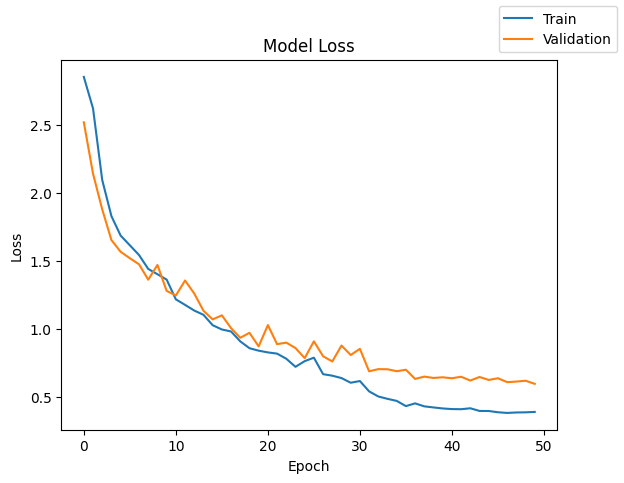

In [ ]:
plotLoss(history2, 'loss')

While early stopping was employed and the model trained for the full 50 epochs, further investigation into the potential benefits of increasing the epoch count is warranted.

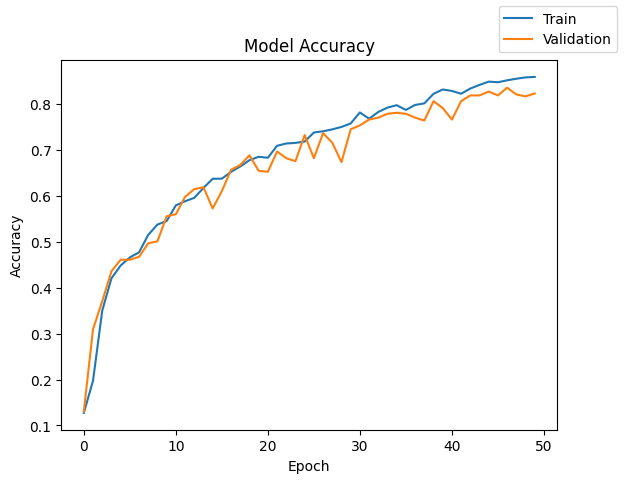

In [ ]:
plotLoss(history2, 'accuracy')

In [ ]:
accuracyTrain = model2.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracyTrain

119/119 - 1s - loss: 0.3621 - accuracy: 0.8726 - 1s/epoch - 12ms/step


[0.3620796203613281, 0.8726315498352051]

In [ ]:
accVal = model2.evaluate(X_val_normalized, y_val_encoded, verbose=2)
accVal

15/15 - 0s - loss: 0.5964 - accuracy: 0.8211 - 193ms/epoch - 13ms/step


[0.5964306592941284, 0.821052610874176]

By incorporating techniques like class weights, data augmentation, and learning rate reduction in Model 2, we observed a notable increase in training accuracy from 0.0.74 (Model 1) to 0.87 (Model 2).




In [ ]:
# calculate y_pred for validation
y_pred2=model2.predict(X_val_normalized)

15/15 [==============================] - 0s 11ms/step


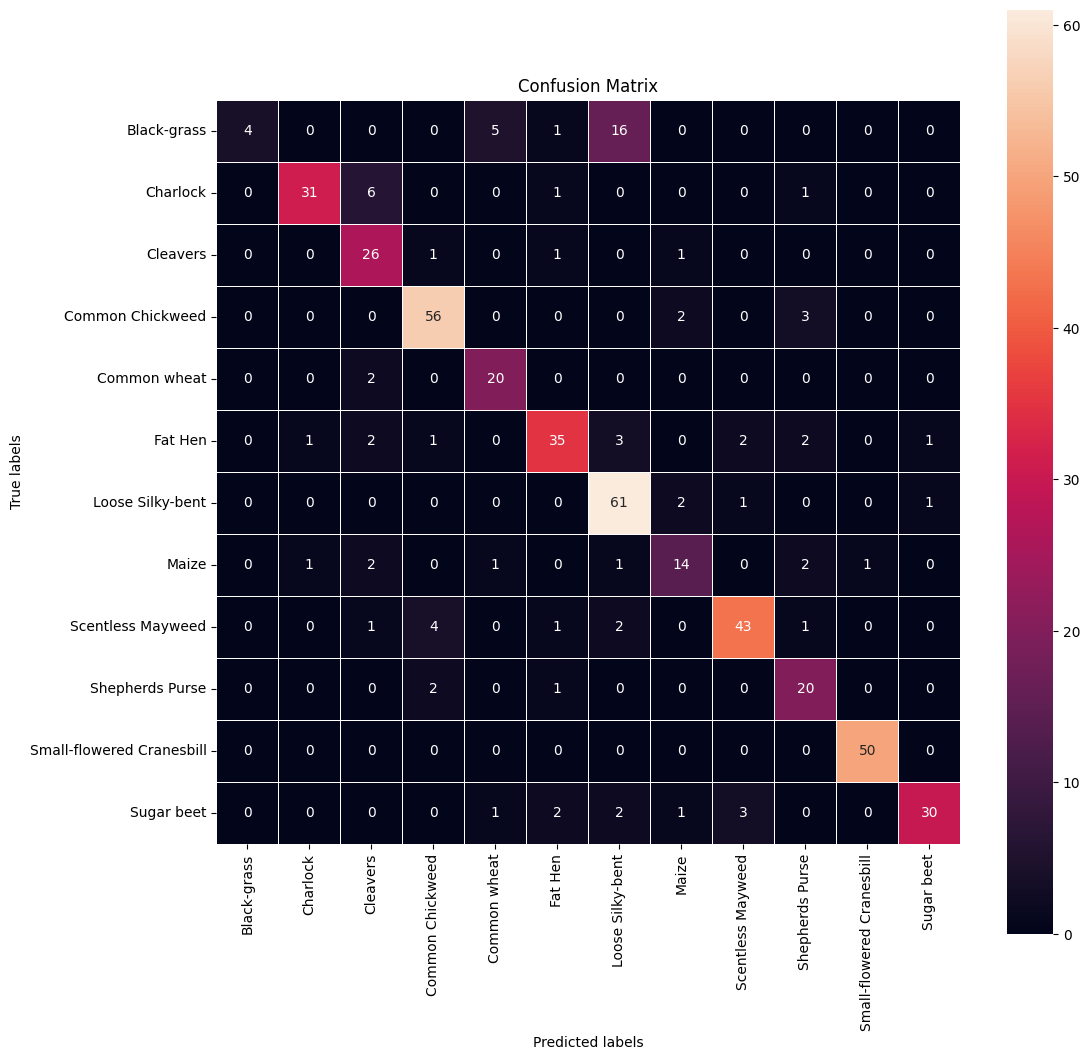

In [ ]:
# confusion matrix for y_val_encoded


# Obtaining the categorical values from y_val_encoded and y_pred
y_pred_arg2=np.argmax(y_pred2,axis=1)
y_val_arg2=np.argmax(y_val_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix2 = tf.math.confusion_matrix(y_val_arg2,y_pred_arg2)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix2,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=0)
plt.show()


Model 2, while demonstrating strong performance overall, exhibits specific areas for improvement based on the confusion matrix analysis. The model frequently misclassifies Black Grass as Loose Silky-bent, Common Wheat as Black Grass, Charlock as Cleavers, and Common Chickweed as Shepherd's Purse . These misclassifications indicate potential challenges in differentiating between visually similar species.

In [ ]:
# calculate the accuracy for each class using validation dataset

# Calculate accuracy for each class
class_accuracy = {}
for i in range(len(enc.classes_)):
    true_positives = confusion_matrix2[i, i] # Remove .numpy() here
    total_samples = np.sum(confusion_matrix2[i, :]) # Remove .numpy() here
    class_accuracy[enc.classes_[i]] = true_positives / total_samples if total_samples > 0 else 0

# Print accuracy for each class
for class_name, accuracy in class_accuracy.items():
    print(f"Accuracy for {class_name}: {accuracy:.2f}")

Accuracy for Black-grass: 0.15
Accuracy for Charlock: 0.79
Accuracy for Cleavers: 0.90
Accuracy for Common Chickweed: 0.92
Accuracy for Common wheat: 0.91
Accuracy for Fat Hen: 0.74
Accuracy for Loose Silky-bent: 0.94
Accuracy for Maize: 0.64
Accuracy for Scentless Mayweed: 0.83
Accuracy for Shepherds Purse: 0.87
Accuracy for Small-flowered Cranesbill: 1.00
Accuracy for Sugar beet: 0.77


In [ ]:
# calculate the precision for each class using validation dataset

# Calculate precision for each class
class_precision = {}
for i in range(len(enc.classes_)):
    true_positives = confusion_matrix2[i, i]
    predicted_positives = np.sum(confusion_matrix2[:, i])
    class_precision[enc.classes_[i]] = true_positives / predicted_positives if predicted_positives > 0 else 0

# Print precision for each class
for class_name, precision in class_precision.items():
    print(f"Precision for {class_name}: {precision:.2f}")

Precision for Black-grass: 1.00
Precision for Charlock: 0.94
Precision for Cleavers: 0.67
Precision for Common Chickweed: 0.88
Precision for Common wheat: 0.74
Precision for Fat Hen: 0.83
Precision for Loose Silky-bent: 0.72
Precision for Maize: 0.70
Precision for Scentless Mayweed: 0.88
Precision for Shepherds Purse: 0.69
Precision for Small-flowered Cranesbill: 0.98
Precision for Sugar beet: 0.94


In [ ]:
cr=classification_report(y_val_arg2,y_pred_arg2)
print(cr)


              precision    recall  f1-score   support

           0       1.00      0.15      0.27        26
           1       0.94      0.79      0.86        39
           2       0.67      0.90      0.76        29
           3       0.88      0.92      0.90        61
           4       0.74      0.91      0.82        22
           5       0.83      0.74      0.79        47
           6       0.72      0.94      0.81        65
           7       0.70      0.64      0.67        22
           8       0.88      0.83      0.85        52
           9       0.69      0.87      0.77        23
          10       0.98      1.00      0.99        50
          11       0.94      0.77      0.85        39

    accuracy                           0.82       475
   macro avg       0.83      0.79      0.78       475
weighted avg       0.84      0.82      0.81       475



### Model 2 - Summary

Model 2 demonstrated a significant improvement in performance, achieving a training accuracy of 0.87 and a validation accuracy of 0.82. This indicates that the model is effectively learning from the training data and generalizing well to unseen data. The techniques employed in Model 2, such as data augmentation, class weights, and learning rate reduction, successfully improved the overfitting issues observed in Model 1.

Model 2 demonstrates strong performance across a majority of seedling classes. Notably, the model achieves exceptional accuracy on classes such as Common Chickweed, Loose Silky-bent, and Small-flowered Cranesbill, with near-perfect classification rates.

Additionally, solid performance is observed for Charlock, Cleavers, Scentless Mayweed, and Shepherds Purse, indicating reliable identification capabilities.

However, the model encounters challenges in accurately classifying Black-grass and Common Wheat, suggesting potential class imbalance or data quality issues. Furthermore, while Maize and Fat Hen exhibit moderate accuracy, there's room for improvement in these categories as well.

Overall, Model 2 showcases promising results, particularly in distinguishing between several seedling types. Nonetheless, further analysis and optimization are required to address the underperforming classes and enhance the model's overall robustness.










#### **Model Comparison**

Model 2 demonstrated improved performance compared to Model 1. The incorporation of class weights, data augmentation, and learning rate reduction effectively addressed the overfitting issues observed in Model 1.

The gap between training and validation accuracy was significantly narrowed, indicating better generalization to unseen data.

In combination, these techniques effectively addressed the overfitting issues present in Model 1, leading to a substantial improvement in validation accuracy (from 0.67 to 0.82) and demonstrating the model's ability to generalize better to unseen data.

Additionally, Model 2 demonstrates superior performance in classifying several seedling types, particularly Common Chickweed, Loose Silky-bent, and Small-flowered Cranesbill. While both models struggled with the differentiation of Loose Silky-bent and Black-grass, Model 2 has shown improvements in this area.

Overall, Model 2 presents a substantial improvement over Model 1 in terms of accuracy, generalization, and robustness. Further refinement, particularly in addressing the classification challenges for Black-grass will be essential for optimizing model performance.

## Model 3 - Transfer learning

For model 3, we'll build the model using Transfer Learning with Data augmentation. We will be loading a pre-built architecture - VGG16, which was trained on the ImageNet dataset.

For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. We will remove the already-present fully-connected layers and add our own fully-connected layers for this classification task.



### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip = True,
                              vertical_flip = False,
                              fill_mode='nearest',
                              rotation_range=20
                              )

In [ ]:
labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight("balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1))

In [ ]:

class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 0.7996632996632996,
 1: 0.8333333333333334,
 2: 1.7117117117117118,
 3: 1.7890772128060264,
 4: 0.6475800954328562,
 5: 1.014957264957265,
 6: 1.3828238719068413,
 7: 0.7686084142394822,
 8: 1.0281385281385282,
 9: 1.7890772128060264,
 10: 1.5007898894154819,
 11: 0.6043256997455471}

In [ ]:
lr = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)


In [ ]:
# defined vgg_model

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (96,96,3))
vgg_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [ ]:
# Clearing backend
backend.clear_session()


In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initializing the model
model3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model3.add(Flatten())

# Adding a dense input layer
model3.add(Dense(64, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(16, activation='relu'))
model3.add(Dropout(0.2))
# ouput layer
model3.add(Dense(12, activation='softmax'))



In [ ]:
# Compiling the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Summary of the model
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 64)                294976    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 12)                2

In [ ]:
# fit model 3 - transfer learning


history3 = model3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=64,
                                       shuffle=False),
                                       epochs=50,validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=2,
                                       class_weight = class_weights,
                                       callbacks=[early_stopping, lr])


Epoch 1/50
60/60 - 13s - loss: 2.6607 - accuracy: 0.1861 - val_loss: 1.9853 - val_accuracy: 0.3284 - lr: 0.0010 - 13s/epoch - 215ms/step
Epoch 2/50
60/60 - 8s - loss: 2.1827 - accuracy: 0.3155 - val_loss: 1.7364 - val_accuracy: 0.4147 - lr: 0.0010 - 8s/epoch - 136ms/step
Epoch 3/50
60/60 - 8s - loss: 1.9280 - accuracy: 0.3803 - val_loss: 1.6477 - val_accuracy: 0.4021 - lr: 0.0010 - 8s/epoch - 135ms/step
Epoch 4/50
60/60 - 8s - loss: 1.8074 - accuracy: 0.4118 - val_loss: 1.5005 - val_accuracy: 0.4695 - lr: 0.0010 - 8s/epoch - 135ms/step
Epoch 5/50
60/60 - 8s - loss: 1.6630 - accuracy: 0.4468 - val_loss: 1.4620 - val_accuracy: 0.4800 - lr: 0.0010 - 8s/epoch - 136ms/step
Epoch 6/50
60/60 - 8s - loss: 1.5794 - accuracy: 0.4795 - val_loss: 1.3431 - val_accuracy: 0.5495 - lr: 0.0010 - 8s/epoch - 135ms/step
Epoch 7/50
60/60 - 8s - loss: 1.5087 - accuracy: 0.4987 - val_loss: 1.3534 - val_accuracy: 0.5642 - lr: 0.0010 - 8s/epoch - 136ms/step
Epoch 8/50
60/60 - 8s - loss: 1.4067 - accuracy: 0.52

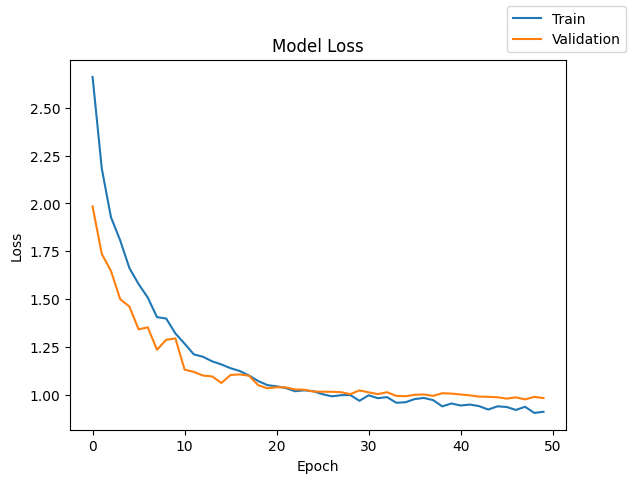

In [ ]:
plotLoss(history3, 'loss')

Loss plot shows some overfitting, but less than model 1 and model 2.

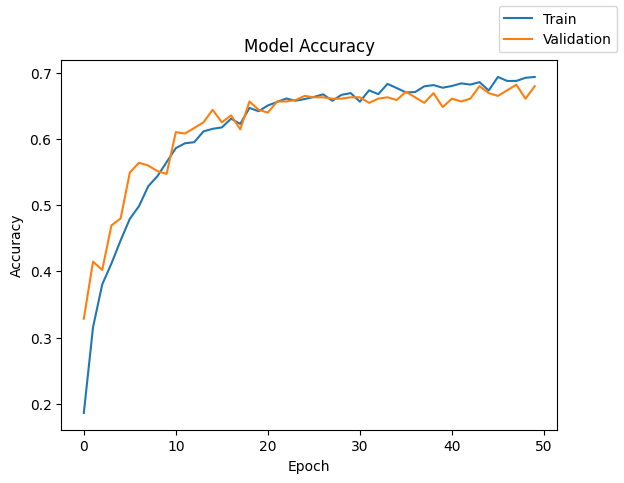

In [ ]:
plotLoss(history3, 'accuracy')

In [ ]:
accuracyTrain = model3.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracyTrain

119/119 - 2s - loss: 0.6856 - accuracy: 0.7724 - 2s/epoch - 17ms/step


[0.6855772137641907, 0.7723684310913086]

In [ ]:
accVal = model3.evaluate(X_val_normalized, y_val_encoded, verbose=2)
accVal

15/15 - 0s - loss: 0.9842 - accuracy: 0.6800 - 268ms/epoch - 18ms/step


[0.9841573238372803, 0.6800000071525574]

In [ ]:
# calculate y_pred for validation
y_pred3=model3.predict(X_val_normalized)

15/15 [==============================] - 0s 16ms/step


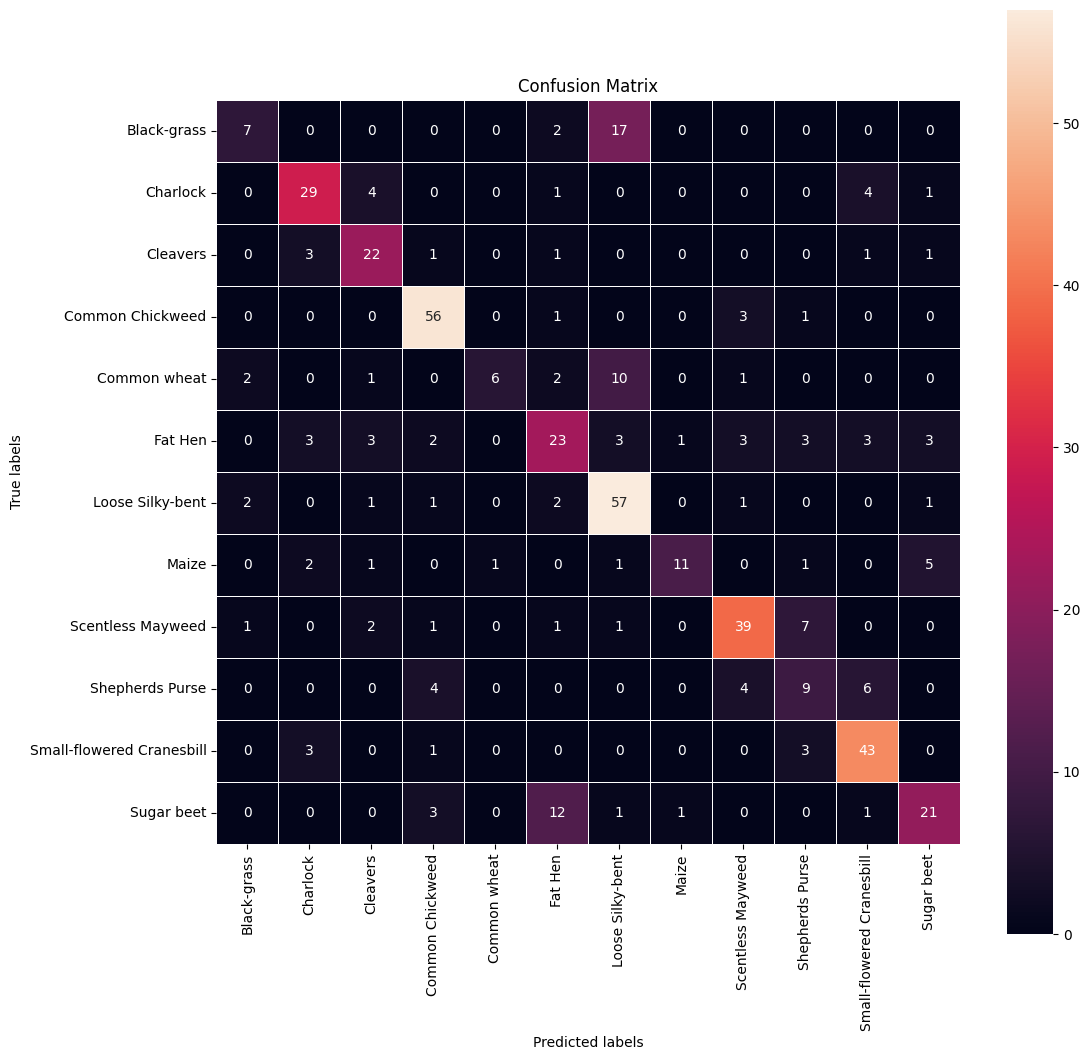

In [ ]:
#  plot a confusion matrix for y_val_encoded


# Obtaining the categorical values from y_val_encoded and y_pred
y_pred_arg3=np.argmax(y_pred3,axis=1)
y_val_arg3=np.argmax(y_val_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix3 = tf.math.confusion_matrix(y_val_arg3,y_pred_arg3)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix3,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=0)
plt.show()


Model 3 exhibits significant confusion between several seedling classes. The most prominent issue is the misclassification of Loose Silky-bent as Black-grass and Fat Hen as Sugar Beet.

In [ ]:
# calculate the accuracy for each class using validation dataset

# Calculate accuracy for each class
class_accuracy = {}
for i in range(len(enc.classes_)):
    true_positives = confusion_matrix3[i, i] # Remove .numpy() here
    total_samples = np.sum(confusion_matrix3[i, :]) # Remove .numpy() here
    class_accuracy[enc.classes_[i]] = true_positives / total_samples if total_samples > 0 else 0

# Print accuracy for each class
for class_name, accuracy in class_accuracy.items():
    print(f"Accuracy for {class_name}: {accuracy:.2f}")

Accuracy for Black-grass: 0.27
Accuracy for Charlock: 0.74
Accuracy for Cleavers: 0.76
Accuracy for Common Chickweed: 0.92
Accuracy for Common wheat: 0.27
Accuracy for Fat Hen: 0.49
Accuracy for Loose Silky-bent: 0.88
Accuracy for Maize: 0.50
Accuracy for Scentless Mayweed: 0.75
Accuracy for Shepherds Purse: 0.39
Accuracy for Small-flowered Cranesbill: 0.86
Accuracy for Sugar beet: 0.54


In [ ]:
# Plotting the classification report
cr3=classification_report(y_val_arg3,y_pred_arg3)
print(cr3)

              precision    recall  f1-score   support

           0       0.58      0.27      0.37        26
           1       0.72      0.74      0.73        39
           2       0.65      0.76      0.70        29
           3       0.81      0.92      0.86        61
           4       0.86      0.27      0.41        22
           5       0.51      0.49      0.50        47
           6       0.63      0.88      0.74        65
           7       0.85      0.50      0.63        22
           8       0.76      0.75      0.76        52
           9       0.38      0.39      0.38        23
          10       0.74      0.86      0.80        50
          11       0.66      0.54      0.59        39

    accuracy                           0.68       475
   macro avg       0.68      0.61      0.62       475
weighted avg       0.69      0.68      0.67       475



### Model 3 Summary

Model 3, which utilized transfer learning with VGG16, yielded a training accuracy of 0.77 and a validation accuracy of 0.68.

Using transfer learning on Model 3 resulted in a decreased accuracy for train and validation and increased overfitting.  It's possible that the ImageNet dataset might not align to this particular use case, and or fine-tuning the VGG16 model might may be needed.

Overall, Model 3, which employed transfer learning with VGG16, demonstrated a decline in performance compared to Model 2. The validation accuracy dropped significantly from 0.82 to 0.68. This indicates that Model 3 may be overfitting to the training data.

The VGG16 architecture might not be optimally suited for the specific task or the dataset might not be sufficiently aligned with the features learned by the pre-trained model.



## Final Model

Model 2 had the best overall performance with accuracy of 0.87 training 0.82 on validation.   We will test the model against the test dataset.  

In [ ]:
accuracyTest = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)
accuracyTest

15/15 - 0s - loss: 0.5236 - accuracy: 0.8295 - 247ms/epoch - 16ms/step


[0.5235857367515564, 0.8294736742973328]

Model 2 accuracy on the test dataset is promising at 0.83.  

### Visualizing the prediction

In [ ]:
y_pred_test=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 11ms/step


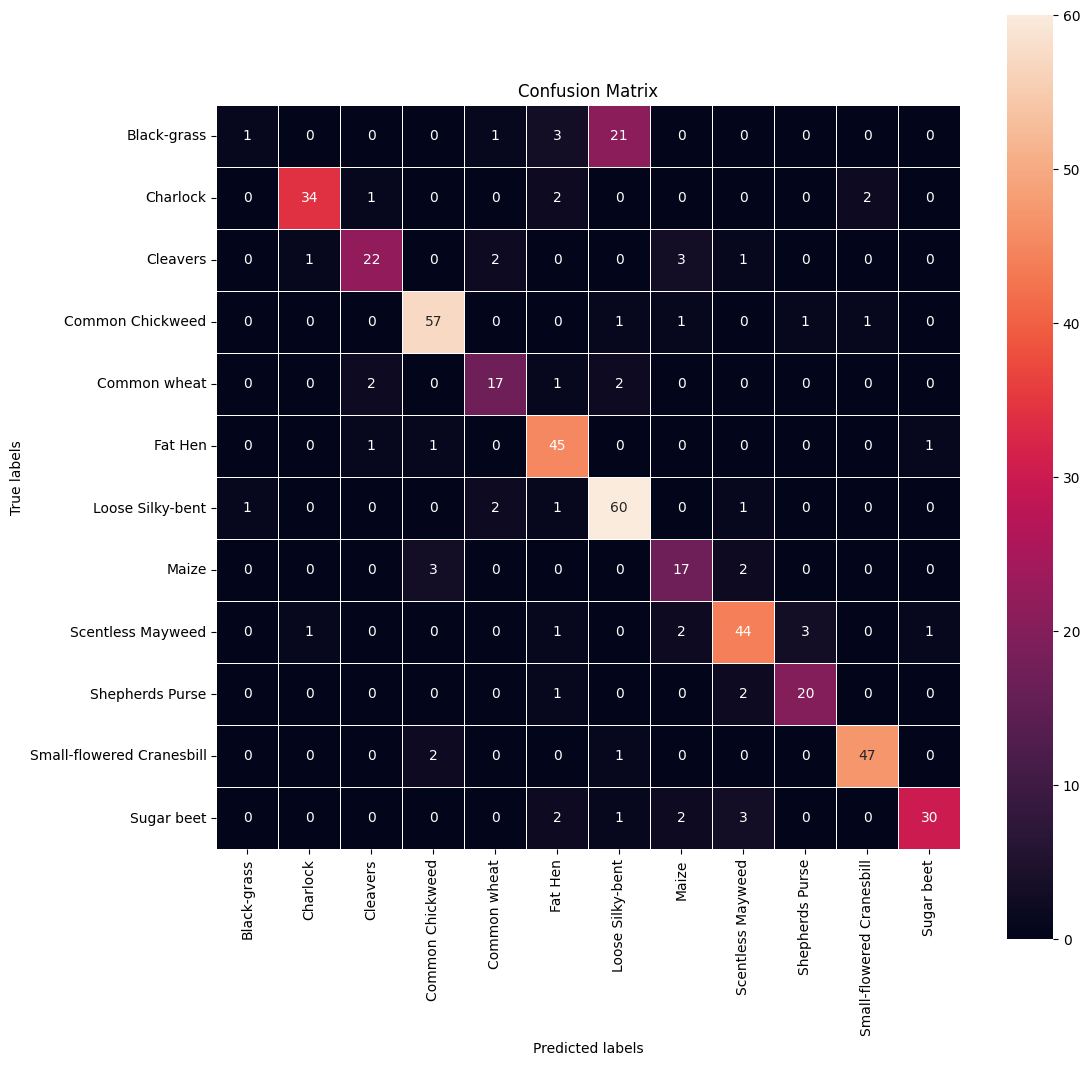

In [ ]:
# calculate y_pred for validation

# Obtaining the categorical values from y_val_encoded and y_pred
y_pred_arg_test=np.argmax(y_pred_test,axis=1)
y_test_arg_test=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrixtest = tf.math.confusion_matrix(y_test_arg_test,y_pred_arg_test)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrixtest,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=0)
plt.show()

Substantial misclassification of Black-grass as Loose Silky-bent

In [ ]:
# Calculate accuracy for each class
class_accuracy = {}
for i in range(len(enc.classes_)):
    true_positives = confusion_matrixtest[i, i] # Remove .numpy() here
    total_samples = np.sum(confusion_matrixtest[i, :]) # Remove .numpy() here
    class_accuracy[enc.classes_[i]] = true_positives / total_samples if total_samples > 0 else 0

# Print accuracy for each class
for class_name, accuracy in class_accuracy.items():
    print(f"Accuracy for {class_name}: {accuracy:.2f}")

Accuracy for Black-grass: 0.04
Accuracy for Charlock: 0.87
Accuracy for Cleavers: 0.76
Accuracy for Common Chickweed: 0.93
Accuracy for Common wheat: 0.77
Accuracy for Fat Hen: 0.94
Accuracy for Loose Silky-bent: 0.92
Accuracy for Maize: 0.77
Accuracy for Scentless Mayweed: 0.85
Accuracy for Shepherds Purse: 0.87
Accuracy for Small-flowered Cranesbill: 0.94
Accuracy for Sugar beet: 0.79


## Actionable Insights and Business Recommendations

Overall, Model 2 demonstrated decent performance on the test dataset, achieving an **accuracy of 0.83**.

**Key Findings:**

- The model exhibits strong performance on several classes, including Charlock, Common Chickweed, Fat Hen, Loose Silky-bent, Small-flowered Cranesbill, and Shepherds Purse, with accuracy values exceeding 0.85. These results suggest that the model effectively distinguishes these plant species from others.

- However, there is room for improvement in classifying Black-grass, Cleavers, Common Wheat, and Maize, as their accuracy scores fall below the overall average. This indicates potential challenges in differentiating these classes from similar-looking plants.


- A critical observation from the confusion matrix is the substantial misclassification of Black-grass as Loose Silky-bent. This indicates a potential challenge for the model in distinguishing these two classes, which may be attributed to visual similarities or insufficient training data.


- The dataset for the model was imbalanced, with Maize, Common Wheat, Shepherds Purse, and Black-grass being underrepresented. This imbalance may have contributed to the lower accuracy scores observed for these classes. To improve the model's performance, it is recommended to collect more data for these underrepresented classes and address the class imbalance issue.


**Recommendations:**

Given the current state of the model, it is advisable to refrain from deploying it into production. To enhance its performance, the following strategies are recommended:

1. **Prioritize Black-grass Classification:**

      **Data Acquisition**: Collect additional data specifically for Black-grass to improve the model's ability to differentiate it from other species.

      **Model Specialization**: Consider creating a dedicated model tailored to distinguishing Black-grass and Loose Silky-bent seedlings.

      **Feature Engineering**: Explore new features that can better highlight the unique characteristics of Black-grass.

2. **Data Augmentation for Improved Generalization:**

      **Image Masking**: Apply image masking techniques to focus the model's attention on specific regions of interest, such as the leaves or stems of the seedlings.

      **Image Equalization**: Enhance the contrast and color balance of the images to highlight the green color of the seedlings.

3. **Optimize Hyperparameters:**

      **Grid Search or Randomized Search**: Conduct systematic experiments to find the optimal values for hyperparameters like learning rate, batch size, and regularization strength.

4. **Address Class Imbalance**:

      **Data Collection**: Obtain more training data for the underrepresented classes, Maize, Common Wheat, Shepherds Purse, and Black-grass.

      **Oversampling or Undersampling**: Employ techniques to balance the class distribution and prevent the model from being biased towards majority classes.



_____